In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_cg

# Exercise 5.1: Linear Regression (dimension-1, power-1, unregularised)
---

Despite being number 5 in the series, this exercise set naturally follows exercise set 1 in terms of theme and complexity. In that earlier work we looked at linear regression for 1D and 2D data sets, both to the first power only, but higher dimensions and higher powers were discussed. All work there was unregularised. Now we increase that complexity, by staying with 1D data but requiring a higher power hypothesis function than a straight line, in order to get the most natural fit. At first we will have a look at a straight line fit just for fun, then introduce higher powers for curvature, and then introduce regularisation after running a scan of the regularisation parameter to select the best one. Along the way we will also look at "_learning curves_", which show how the final cost, as given by the optimum $\overrightarrow{\theta}$ parameters, changes for both the training data and the cross-validation data as the number of training examples is increased. Let's begin by having a look at the data to be used throughout all of this exercise set:

In [42]:
d1 = loadmat('ex5/ex5data1.mat')
d1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [43]:
d1_X = d1['X']
d1_X.shape

(12, 1)

In [44]:
d1_y = d1['y']
d1_y.shape

(12, 1)

In [45]:
d1_Xval = d1['Xval']
d1_Xval.shape

(21, 1)

In [46]:
d1_yval = d1['yval']
d1_yval.shape

(21, 1)

In [47]:
d1_Xtest = d1['Xtest']
d1_Xtest.shape

(21, 1)

In [48]:
d1_ytest = d1['ytest']
d1_ytest.shape

(21, 1)

In [49]:
del(d1)

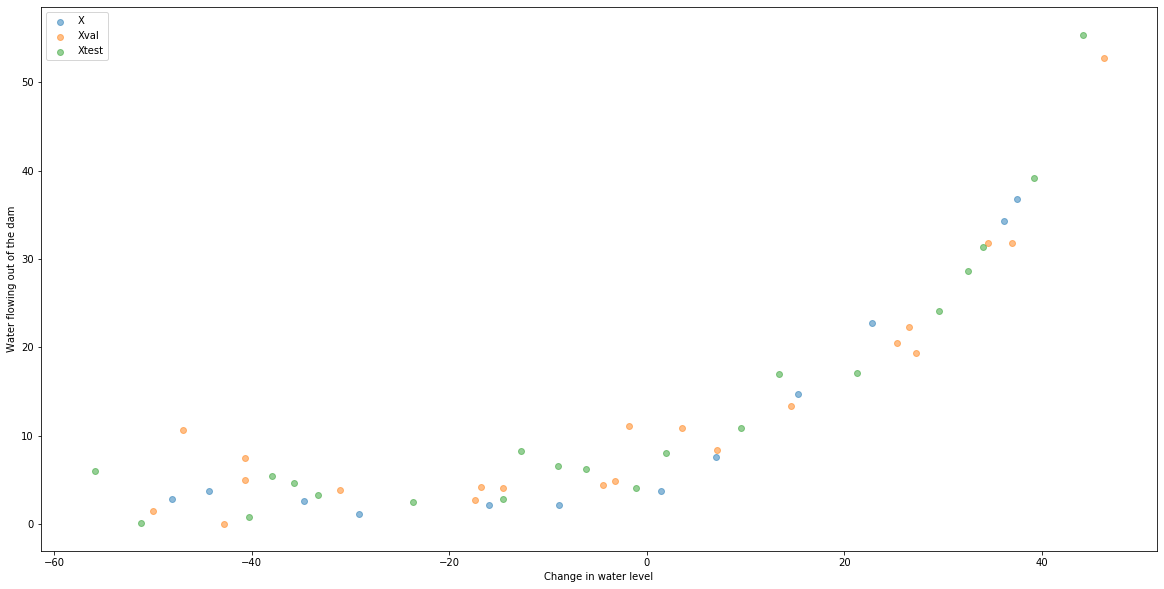

In [50]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X, d1_y, color='C0', alpha=0.5)
ax.scatter(d1_Xval, d1_yval, color='C1', alpha=0.5)
ax.scatter(d1_Xtest, d1_ytest, color='C2', alpha=0.5)
ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam')
ax.legend(['X', 'Xval', 'Xtest'])
plt.show()

---

Let's make a function to include an offset term via the dummy feature $x_0 = 1$:

In [11]:
def add_ones(X):
    return(np.append(np.ones([X.shape[0],1]), X, axis=1))

In [12]:
d1_X_ones = add_ones(d1_X)
d1_X_ones.shape

(12, 2)

In [13]:
d1_Xval_ones = add_ones(d1_Xval)
d1_Xval_ones.shape

(21, 2)

---

Now define the cost function, which includes regularisation terms for later use. Note that rather than being called by our own hand crafted gradient descent function, this will be called by the optimisation function ``fmin_cg`` (I'm unsure of the differences between this and ``fmin_bfgs`` used in ex2), which can calculate the required derivatives internally, hence the derivative toggle switch in the following. Also note that this optimisation function works exclusively with row vectors for the $\overrightarrow{\theta}$ parameters, hence the check and conversion to a column vector at the start of the function, for internal consistency:

In [14]:
def get_cost_reg(
    theta,
    lamb,
    X,
    y,
    get_derivative=True,
):

    if (theta.ndim == 1):
        theta = np.transpose([theta])

    m = X.shape[0]
    h = np.dot(X, theta) # These are the predictions for the y values we're trying to match i.e. h is an array of the same size as y
    h_minus_y = h - y

    cost = \
          (1 / (2 * m)) \
        * np.sum(np.power(h_minus_y, 2)) \
        + (lamb / (2 * m)) * np.sum(np.power(theta[1:], 2))

    if (not get_derivative):
        return(cost)
    else:
        dcost_by_dtheta = (1 / m) * np.dot(np.transpose(X), h_minus_y)
        dcost_by_dtheta[1:] += (lamb / m) * theta[1:]
        return(cost, dcost_by_dtheta)

In [15]:
def get_theta(
    theta_init,
    lamb,
    iters_num,
    X,
    y,
    disp=True,
):

    theta = fmin_cg(
        get_cost_reg,
        theta_init,
        args=(
            lamb,
            X,
            y,
            False,
        ),
        maxiter=iters_num,
        disp=disp,
    )

    theta = np.transpose([theta])

    return(theta)

In [39]:
d1_cost, d1_dcost_by_dtheta = get_cost_reg(
    np.array([[1.0],[1.0]]),
    1,
    d1_X_ones,
    d1_y,
)
print(d1_cost)
print(d1_dcost_by_dtheta)
# 303.9931922202643
# [[-15.30301567]
#  [598.25074417]]

303.9931922202643
[[-15.30301567]
 [598.25074417]]


---

Run the optimisation function to find the optimum $\overrightarrow{\theta}$ for an unregularised straight line fit i.e. just using the first power of the independent variable, or, in other words, just using the data as given. This is exactly the same as what we did in exercise 1.2, except using the established optimisation function rather than our own gradient descent function:

In [17]:
d1_theta_p1 = get_theta(
    np.array([[0.0],[0.0]]),
    0,
    200,
    d1_X_ones,
    d1_y,
)
print(d1_theta_p1)
# Optimization terminated successfully.
#          Current function value: 22.373906
#          Iterations: 3
#          Function evaluations: 28
#          Gradient evaluations: 7
# array([13.0878989 ,  0.36777919])

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 3
         Function evaluations: 28
         Gradient evaluations: 7
[[13.0878989 ]
 [ 0.36777919]]


Let's see the fit according to the parameters found:

In [18]:
d1_X1_range = max(d1_X[:,0]) - min(d1_X[:,0])
d1_Xfit1_lower = min(d1_X[:,0]) - (d1_X1_range * 0.2)
d1_Xfit1_upper = max(d1_X[:,0]) + (d1_X1_range * 0.2)

d1_Xfit = np.transpose([np.linspace(d1_Xfit1_lower, d1_Xfit1_upper, 100)])
d1_Xfit_ones = np.append(np.ones([d1_Xfit.shape[0],1]), d1_Xfit, axis=1)

d1_hfit = np.dot(d1_Xfit_ones, d1_theta_p1)

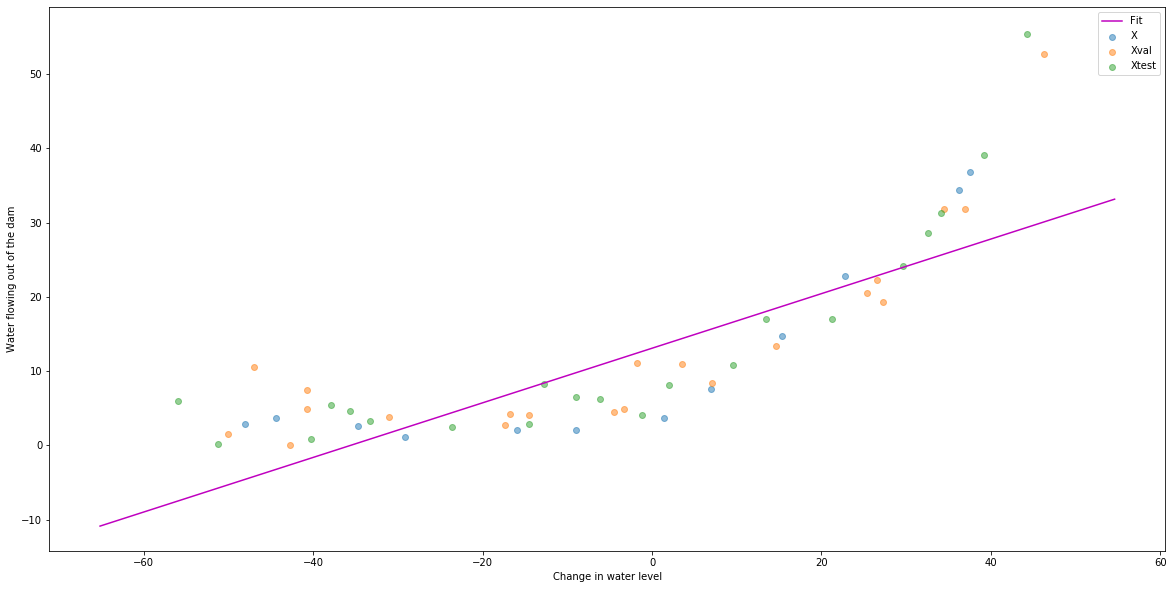

In [19]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X, d1_y, color='C0', alpha=0.5)
ax.scatter(d1_Xval, d1_yval, color='C1', alpha=0.5)
ax.scatter(d1_Xtest, d1_ytest, color='C2', alpha=0.5)
ax.plot(d1_Xfit, d1_hfit, '-', color='m')
ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam')
ax.legend(['Fit', 'X', 'Xval', 'Xtest']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

# Exercise 5.2: Learning Curves
---

Before moving on to try and improve the fit, let's first take a small detour and plot "_learning curves_". These show how the overall cost for the final optimum $\overrightarrow{\theta}$ varies with the number of training examples, for both training and cross-validation sets. If the hypothesis function being used to fit the data is adequate, then we would expect the cost for the training data to reduce with more examples. As it is though, for the straight line fit to curved data, we see that this cost actually increases with more examples. This is because there are more points which further highlight the inadequacy of the hypothesis function:

In [20]:
d1_X_ones_costs = []
d1_Xval_ones_costs = []

for ex_idx in range(1, d1_X.shape[0]+1):

    theta = get_theta(
        np.array([[0.0],[0.0]]),
        0,
        200,
        d1_X_ones[0:ex_idx],
        d1_y[0:ex_idx],
        False,
    )

    # lambda must be zero in the following, regardless of that used to train theta:

    cost = get_cost_reg(
        theta,
        0,
        d1_X_ones[0:ex_idx],
        d1_y[0:ex_idx],
        False,
    )
    d1_X_ones_costs.append(cost)

    cost = get_cost_reg(
        theta,
        0,
        d1_Xval_ones,
        d1_yval,
        False,
    )
    d1_Xval_ones_costs.append(cost)

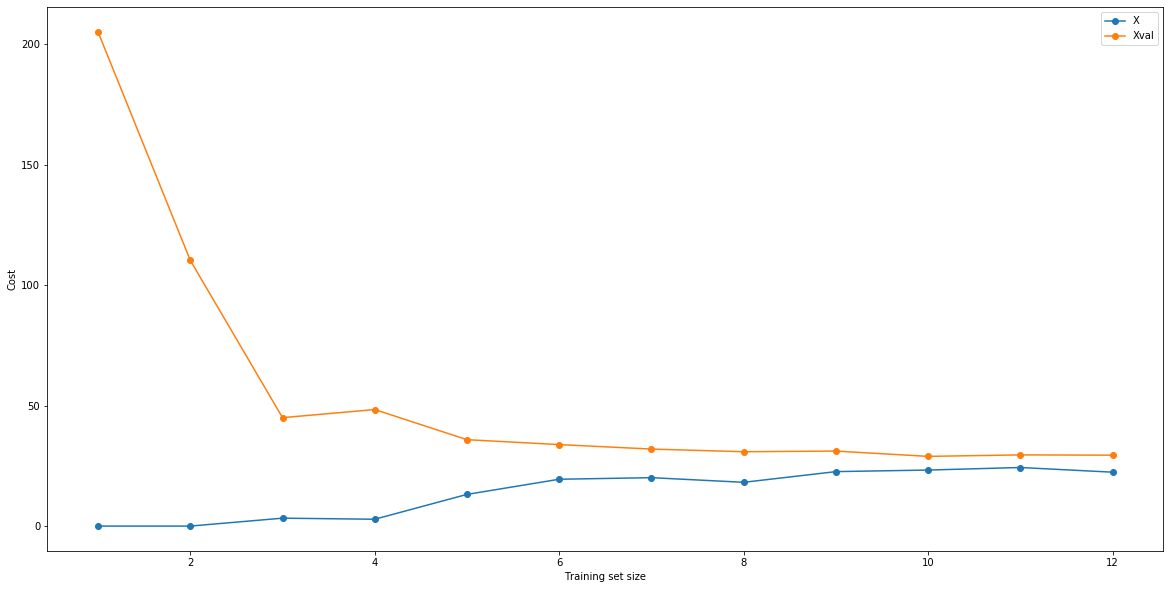

In [21]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(1, d1_X.shape[0]+1), d1_X_ones_costs, 'o-', color='C0')
ax.plot(range(1, d1_X.shape[0]+1), d1_Xval_ones_costs, 'o-', color='C1')
ax.set(xlabel='Training set size', ylabel='Cost')
ax.legend(['X', 'Xval'])
plt.show()

# Exercise 5.3: Linear Regression (dimension-1, power-8, unregularised, regularised)
---

So we've done a straight line fit and seen that it does not match the curved data well. No surprises. Now let's do a polynomial fit by taking higher powers of the single input dimension, which thus provides more features. After this "_feature mapping_", we then normalise each of the features individually, just like we did in exercise 1.3, but where in that case we had more dimensions rather than more powers of a single dimension to increase the feature count. We will eventually require the same transformations to be done on the cross-validation and test data as well, so let's just define some transformation functions and do all the data preparation here in advance:

In [22]:
def add_features(
    X,
    degrees_num,
):

    X_features = X

    for degree in range(2, degrees_num+1):
        X_features = np.append(X_features, np.power(X, degree), axis=1)

    return(X_features)

In [23]:
def normalise(X):

    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma

    return(X_norm, mu, sigma)

In [24]:
degrees_num = 8
d1_X_features = add_features(d1_X, degrees_num)
d1_X_features_norm, d1_mu, d1_sigma = normalise(d1_X_features)
d1_X_features_norm_ones = add_ones(d1_X_features_norm)

In [25]:
d1_Xval_features = add_features(d1_Xval, degrees_num)
d1_Xval_features_norm = (d1_Xval_features - d1_mu) / d1_sigma
d1_Xval_features_norm_ones = add_ones(d1_Xval_features_norm)

In [26]:
d1_Xtest_features = add_features(d1_Xtest, degrees_num)
d1_Xtest_features_norm = (d1_Xtest_features - d1_mu) / d1_sigma
d1_Xtest_features_norm_ones = add_ones(d1_Xtest_features_norm)

---

Run the optimisation function to find the optimum $\overrightarrow{\theta}$ for an unregularised polynomial fit:

In [27]:
d1_theta_p8 = get_theta(
    np.array([[0.0]] * (degrees_num + 1)),
    0,
    200,
    d1_X_features_norm_ones,
    d1_y,
)
print(d1_theta_p8)
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.135490
#          Iterations: 200
#          Function evaluations: 4070
#          Gradient evaluations: 370
# [[ 11.21935223]
#  [ 10.87157628]
#  [ 14.34236026]
#  [ 11.04448569]
#  [-12.94424096]
#  [-15.69311971]
#  [  8.38622103]
#  [  4.97004288]
#  [ -4.63943393]]

         Current function value: 0.135490
         Iterations: 200
         Function evaluations: 4070
         Gradient evaluations: 370
[[ 11.21935223]
 [ 10.87157628]
 [ 14.34236026]
 [ 11.04448569]
 [-12.94424096]
 [-15.69311971]
 [  8.38622103]
 [  4.97004288]
 [ -4.63943393]]


Let's see the fit according to the parameters found:

In [28]:
d1_X1_range = max(d1_X[:,0]) - min(d1_X[:,0])
d1_Xfit1_lower = min(d1_X[:,0]) - (d1_X1_range * 0.2)
d1_Xfit1_upper = max(d1_X[:,0]) + (d1_X1_range * 0.2)

d1_Xfit = np.transpose([np.linspace(d1_Xfit1_lower, d1_Xfit1_upper, 100)])
d1_Xfit_features = add_features(d1_Xfit, degrees_num)
d1_Xfit_features_norm = (d1_Xfit_features - d1_mu) / d1_sigma
d1_Xfit_features_norm_ones = add_ones(d1_Xfit_features_norm)

d1_hfit = np.dot(d1_Xfit_features_norm_ones, d1_theta_p8)

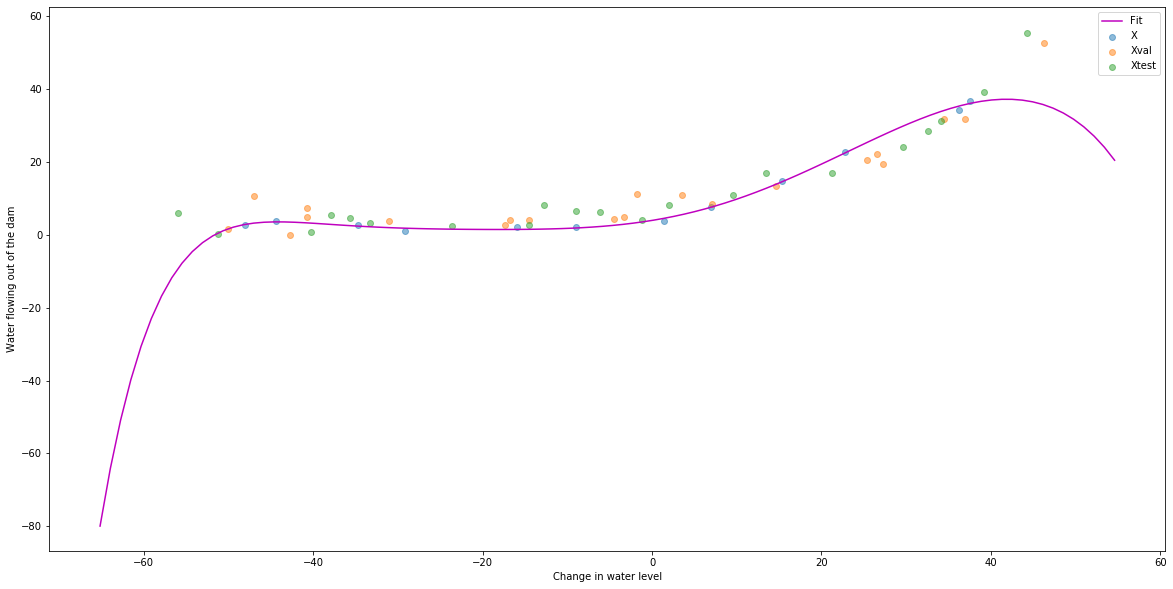

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X, d1_y, color='C0', alpha=0.5)
ax.scatter(d1_Xval, d1_yval, color='C1', alpha=0.5)
ax.scatter(d1_Xtest, d1_ytest, color='C2', alpha=0.5)
ax.plot(d1_Xfit, d1_hfit, '-', color='m')
ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam')
ax.legend(['Fit', 'X', 'Xval', 'Xtest']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

The fit is now much better with polynomial features, but which we can see is overfit to the training data as we did not use regularisation above (i.e. lambda was set to zero), as the curve veers away from both the cross-validation and test data at the extremes. If we have another look at the learning curves before addressing this issue, we see that the training set cost does not increase with training set size, as we saw previously for the power-1 fit, further indicating that the new polynomial features do indeed help to produce a better fit, as also indicated by the lower curve for the cross-validation cost too:

In [30]:
d1_X_features_norm_ones_costs = []
d1_Xval_features_norm_ones_costs = []

for ex_idx in range(1, d1_X.shape[0]+1):

    theta = get_theta(
        np.array([[0.0]] * (degrees_num + 1)),
        0,
        200,
        d1_X_features_norm_ones[0:ex_idx],
        d1_y[0:ex_idx],
        False,
    )

    # lambda must be zero in the following, regardless of that used to train theta:

    cost = get_cost_reg(
        theta,
        0,
        d1_X_features_norm_ones[0:ex_idx],
        d1_y[0:ex_idx],
        False,
    )
    d1_X_features_norm_ones_costs.append(cost)

    cost = get_cost_reg(
        theta,
        0,
        d1_Xval_features_norm_ones,
        d1_yval,
        False,
    )
    d1_Xval_features_norm_ones_costs.append(cost)

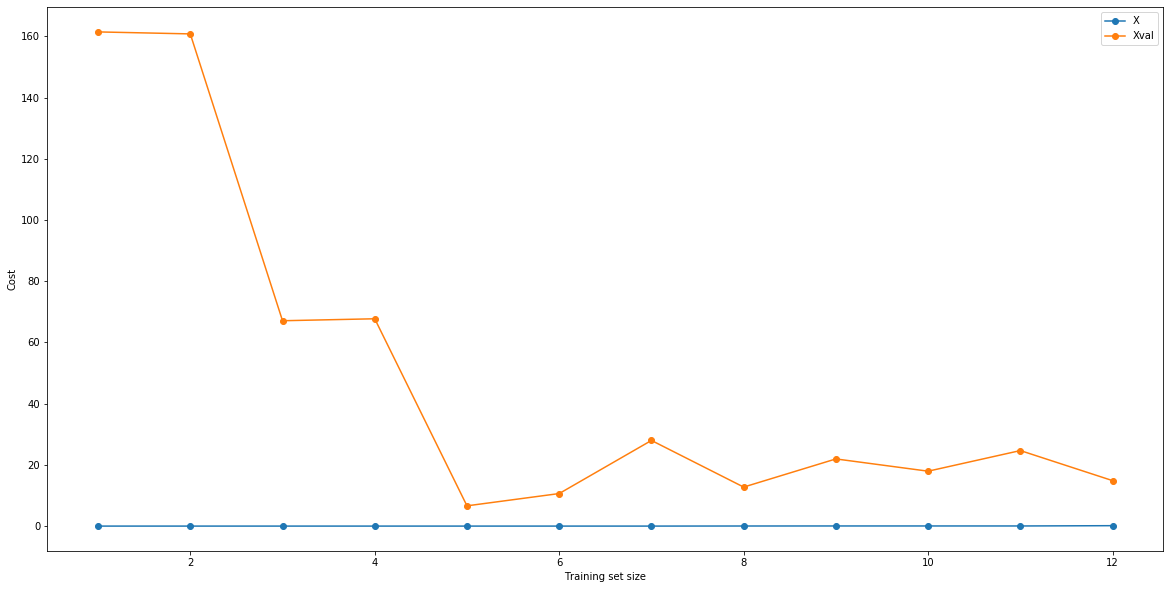

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(range(1, d1_X.shape[0]+1), d1_X_features_norm_ones_costs, 'o-', color='C0')
ax.plot(range(1, d1_X.shape[0]+1), d1_Xval_features_norm_ones_costs, 'o-', color='C1')
ax.set(xlabel='Training set size', ylabel='Cost')
ax.legend(['X', 'Xval'])
plt.show()

---

Finally let's get on with some regularisation, which is the next step that we can make in order to try and improve things, in addition to the polynomial features already introduced. Rather than attempting various regularisation parameters randomly, let's do a proper scan in order to try and find the best one in a more systematic fashion. We'll then use that value of lambda to run the polynomial fit again and obtain the final say on the optimum $\overrightarrow{\theta}$:

In [32]:
d1_lambs = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

d1_X_features_norm_ones_costs = []
d1_Xval_features_norm_ones_costs = []

for d1_lamb in d1_lambs:

    theta = get_theta(
        np.array([[0.0]] * (degrees_num + 1)),
        d1_lamb,
        200,
        d1_X_features_norm_ones,
        d1_y,
        False,
    )

    # lambda must be zero in the following, regardless of that used to train theta:

    cost = get_cost_reg(
        theta,
        0,
        d1_X_features_norm_ones,
        d1_y,
        False,
    )
    d1_X_features_norm_ones_costs.append(cost)

    cost = get_cost_reg(
        theta,
        0,
        d1_Xval_features_norm_ones,
        d1_yval,
        False,
    )
    d1_Xval_features_norm_ones_costs.append(cost)

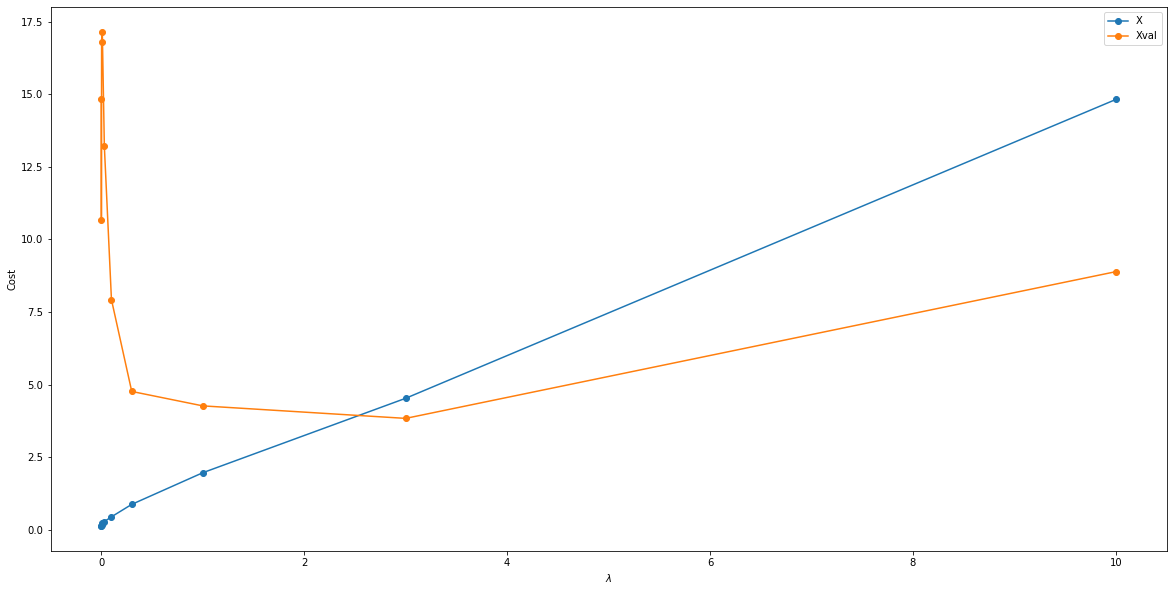

In [33]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(d1_lambs, d1_X_features_norm_ones_costs, 'o-', color='C0')
ax.plot(d1_lambs, d1_Xval_features_norm_ones_costs, 'o-', color='C1')
ax.set(xlabel=r'$\lambda$', ylabel='Cost')
ax.legend(['X', 'Xval'])
plt.show()

In [34]:
d1_lamb_best = d1_lambs[np.argmin(d1_Xval_features_norm_ones_costs)]
print(d1_lamb_best)

3


---

Run the optimisation function to find the optimum $\overrightarrow{\theta}$ for a regularised polynomial fit:

In [35]:
d1_theta_p8_reg = get_theta(
    np.array([[0.0]] * (degrees_num + 1)),
    d1_lamb_best,
    200,
    d1_X_features_norm_ones,
    d1_y,
)
print(d1_theta_p8_reg)
# Optimization terminated successfully.
#          Current function value: 14.937646
#          Iterations: 17
#          Function evaluations: 330
#          Gradient evaluations: 30
# [[11.21759731]
#  [ 6.52208705]
#  [ 3.82486598]
#  [ 3.61984208]
#  [ 2.18397868]
#  [ 2.10604778]
#  [ 1.2807823 ]
#  [ 1.28791011]
#  [ 0.72491904]]

Optimization terminated successfully.
         Current function value: 14.937646
         Iterations: 17
         Function evaluations: 330
         Gradient evaluations: 30
[[11.21759731]
 [ 6.52208705]
 [ 3.82486598]
 [ 3.61984208]
 [ 2.18397868]
 [ 2.10604778]
 [ 1.2807823 ]
 [ 1.28791011]
 [ 0.72491904]]


Let's see the fit according to the parameters found:

In [36]:
d1_X1_range = max(d1_X[:,0]) - min(d1_X[:,0])
d1_Xfit1_lower = min(d1_X[:,0]) - (d1_X1_range * 0.2)
d1_Xfit1_upper = max(d1_X[:,0]) + (d1_X1_range * 0.2)

d1_Xfit = np.transpose([np.linspace(d1_Xfit1_lower, d1_Xfit1_upper, 100)])
d1_Xfit_features = add_features(d1_Xfit, degrees_num)
d1_Xfit_features_norm = (d1_Xfit_features - d1_mu) / d1_sigma
d1_Xfit_features_norm_ones = add_ones(d1_Xfit_features_norm)

d1_hfit = np.dot(d1_Xfit_features_norm_ones, d1_theta_p8_reg)

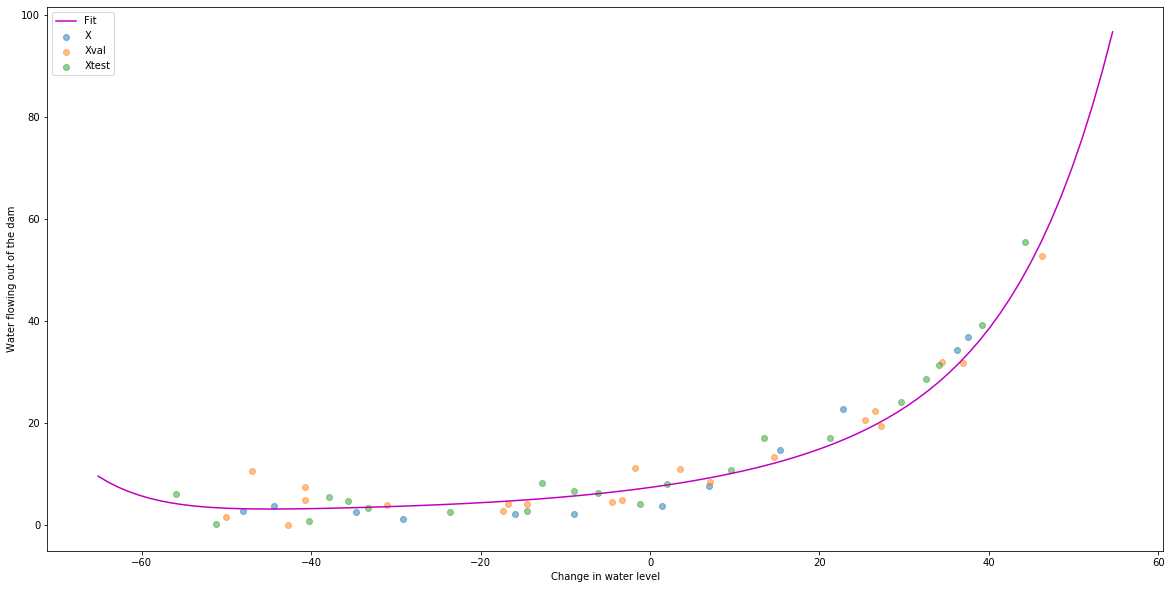

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.scatter(d1_X, d1_y, color='C0', alpha=0.5)
ax.scatter(d1_Xval, d1_yval, color='C1', alpha=0.5)
ax.scatter(d1_Xtest, d1_ytest, color='C2', alpha=0.5)
ax.plot(d1_Xfit, d1_hfit, '-', color='m')
ax.set(xlabel='Change in water level', ylabel='Water flowing out of the dam')
ax.legend(['Fit', 'X', 'Xval', 'Xtest']) # Dunno why, but the legend always puts the 'plot' style before the 'scatter' style, regardless of the above ordering
plt.show()

---

Now we have the best fit seen so far, when we take into account the adherence to the cross-validation set and the test set as well as the training set.

Last but not least, let's find the cost of using the latest theta with respect to all data sets in hand:

In [38]:
d1_X_features_norm_ones_cost = get_cost_reg(d1_theta_p8_reg, 0, d1_X_features_norm_ones, d1_y, False)
d1_Xval_features_norm_ones_cost = get_cost_reg(d1_theta_p8_reg, 0, d1_Xval_features_norm_ones, d1_yval, False)
d1_Xtest_features_norm_ones_cost = get_cost_reg(d1_theta_p8_reg, 0, d1_Xtest_features_norm_ones, d1_ytest, False)
print(d1_X_features_norm_ones_cost)
print(d1_Xval_features_norm_ones_cost)
print(d1_Xtest_features_norm_ones_cost)
# 4.525108373414451
# 3.832175023784651
# 3.5720178496058685

4.525108373414451
3.832175023784651
3.5720178496058685
